* [x] Get data into csv to work in pandas
* [x] Perform sentiment classification with Hugging Face model (2024 SOTA)
* [ ] Extract from text key words that resulted in sentiment class (entity-based sentiment analysis)
* [x] topic modeling
* [ ] other advanced analytics for reviews using LLM/HuggingFace
* [ ] compare competition side-by-side (Japanese restaurants)
* [ ] get criteria for ranking/qualities in restaurant based on aggregation of common words through clustering

In [1]:
!pip install duckdb jupysql -q transformers torch setfit --quiet 
!python -m spacy download en_core_web_md --quiet

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [2]:
!pip install setfit --quiet

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)
import duckdb

%load_ext sql
conn = duckdb.connect()
%sql conn --alias duckdb

import re
from collections import Counter

# Viz
import matplotlib.pyplot as plt

import torch
from transformers import pipeline, AutoTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer # Vader

from nltk.corpus import stopwords

# Topic Modeling
import spacy
nlp = spacy.load('en_core_web_md')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

Deploy Shiny apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


2024-05-28 05:58:56.133231: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 05:58:56.133383: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 05:58:56.308140: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [5]:
dfr = pd.read_csv('/kaggle/input/yelp-revised/yelp_biz_rev.csv')
dfr.head()

/tmp/ipykernel_19/3121522079.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  dfr = pd.read_csv('/kaggle/input/yelp-revised/yelp_biz_rev.csv')


,Unnamed: 0,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,categories,review_id,user_id,review_stars,text,date
0,0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",BXQcBN0iAi1lAUxibGLFzA,6_SpY41LIHZuIaiDs5FMKA,4.0,"This is nice little Chinese bakery in the heart of Philadelphia's Chinatown! The female cashier was very friendly (flirtatious!) and the pastries shown in nicely adorned display cases. I stopped by early one evening had a sesame ball, which was filled with bean paste. The glutinous rice of the ball was nicely flavored, similar to Bai Tang Gao. Definitely as place worth stopping at if you are in the area.",2014-05-26 01:09:53
1,1,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",uduvUCvi9w3T2bSGivCfXg,tCXElwhzekJEH6QJe3xs7Q,4.0,"This is the bakery I usually go to in Chinatown. They have a decent variety of buns and pastries. Red bean-filled buns, mung bean-filled buns, coconut stuff, egg tarts etc. If you buy a dozen, they will give you two more for free. The prices are standard for a Chinese bakery, with most things at approximately $1. The service has always been good. They do serve coffee and tea. There are a couple of tables inside, with usually the expected group of older Chinese guys chillin' in the corner table debating about something. Great place to stock up on the buns, which I usually do before leaving town.",2013-10-05 15:19:06
2,2,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",a0vwPOqDXXZuJkbBW2356g,WqfKtI-aGMmvbA9pPUxNQQ,5.0,"A delightful find in Chinatown! Very clean, and very kind service. Everyone always seems happy in here, and their treats are absolutely delicious. You can also get a ton of sweet treats without any judgement! They're my favorite.",2013-10-25 01:34:57
3,3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",MKNp_CdR2k2202-c8GN5Dw,3-1va0IQfK-9tUMzfHWfTA,5.0,I ordered a graduation cake for my niece and 

In [6]:
query = """
select review_id
, review_stars
, text
from dfr
"""

df_sent2 = duckdb.query(query).df()
df_sent2

,review_id,review_stars,text
0,BXQcBN0iAi1lAUxibGLFzA,4.0,"This is nice little Chinese bakery in the heart of Philadelphia's Chinatown! The female cashier was very friendly (flirtatious!) and the pastries shown in nicely adorned display cases. I stopped by early one evening had a sesame ball, which was filled with bean paste. The glutinous rice of the ball was nicely flavored, similar to Bai Tang Gao. Definitely as place worth stopping at if you are in the area."
1,uduvUCvi9w3T2bSGivCfXg,4.0,"This is the bakery I usually go to in Chinatown. They have a decent variety of buns and pastries. Red bean-filled buns, mung bean-filled buns, coconut stuff, egg tarts etc. If you buy a dozen, they will give you two more for free. The prices are standard for a Chinese bakery, with most things at approximately $1. The service has always been good. They do serve coffee and tea. There are a couple of tables inside, with usually the expected group of older Chinese guys chillin' in the corner table debating about something. Great place to stock up on the buns, which I usually do before leaving town."
2,a0vwPOqDXXZuJkbBW2356g,5.0,"A delightful find in Chinatown! Very clean, and very kind service. Everyone always seems happy in here, and their treats are absolutely delicious. You can also get a ton of sweet treats without any judgement! They're my favorite."
3,MKNp_CdR2k2202-c8GN5Dw,5.0,I ordered a graduation cake for my niece and it came out absolutely perfect. Will come again for future events! Staff was nice also and the cake was really good.
4,D1GisLDPe84Rrk_R4X2brQ,4.0,"HK-STYLE MILK TEA: FOUR STARS\n\nNot quite sure why there are two Saint Honore Pastries business listings on Yelp, but I have been checking in to this one.\n\nBoyfriend and I go by it all the time while in Chinatown, but it never crossed our mind to try it. I think we might have tried it once a year or two ago, but it wasn't memorable. I decided to try the HK-style milk tea not too long ago and was hooked. I think I went here almost every day one week to get the milk tea, only to realize that I should REALLY watch my sugar intake...it's sooo good! \n\nI personally don't think it's better than Zhong Gang's HK-style milk tea because they have their off days when a certain lady makes them (not enough ice, too much ice, etc.).\n\nOn a side note: I wanted to try the crispy roast pork bun, but accidentally said the wrong name in Chinese and got the roast pork bun. It was decent enough, although I will get to trying the crispy roast pork bun soon! \n\nI will be back~"
...,...,...,...
3773767,Kt3gFeW1rhZz7RuiV-6Tcw,5.0,"This is my favorite food truck! I only wish I lived closer to Philly so that I could eat here more often. The prices are affordable, the portions are generous, the staff is friendly, and the food is AMAZING. \n\nThe last time I went to the Plum Pit, I ordered a jerk chicken sandwich to split with a friend. Learn from our mistake--order your own sandwich, and if you can't finish it, save half for later. We ended up going back for another sandwich (the one with chicken tenders, mac & cheese, and bacon--I can't remember the name) anyway. We also got two orders of bread pudding to bring home, which, though pretty good cold, is ever better when you heat it up in the oven for 10-15 minutes."
3773768,ruy3Ycey_gGbwkE_3TX1Fg,5.0,"This food truck was stupid. Stupidly delicious. \n\nShould be a 4.5 because they were a little slow compared to other trucks, but once the food showed up, totally ON POINT.\n\nWe had the bacon Mac and cheese with the French fry bowl, topped with jerk chicken. I could not get enough of the jerk chicken. And the bacon Mac and cheese was super creamy ( again 4.5 we saw a big can of nacho cheese instead of good cheese "" . \n\nWould definitely eat here again if they were at the Stables."
3773769,C_l8NTpvNOEUorEmEOusaA,5.0,Bubba never disappoints i go to his fb page and hunt him down and now i have my friends and family stalking him too. One of the main r

In [7]:
# reduce file size by getting sample
#sample 500,000 to use less RAM
sample = df_sent2.sample(n=500000)
len(sample)

500000

In [8]:
sample.head(1)

,review_id,review_stars,text
644959,D5megVNJnm-evUTZBEJpVA,5.0,"Great food for a decent price. In a shopping center where you'd expect to find nasty chain restaurants, like Chile's and Applebee's.... Don't let the line fool you, I hate lines and that was my first impression of this place is, great a huge line, but it moves fast. As bad as lines are they also mean the food is probably good. I ordered the carne aside sopes, the gf got the Chiles Nortenos with shrimp. I also ordered a side of guac. Both meals were great, I've had sopes in Mexico and the ones here were just as good. The Chiles Nortenos were amazing. Rice and beans were great and their salsa bar was awesome. Guac was decent too."


# Text Pre-Processing

In [9]:
# text column needs to be changed to string...
sample['text'] = sample['text'].apply(str)

In [10]:
# Get code to clean text of HTML tags, punctuation
def cleanhtml(x): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', x) 
    return cleantext.replace('\n\n', ' ').replace('\n', '')
    
sample['clean_text'] = sample.apply(lambda row: cleanhtml(row['text']), axis=1)

# Examine sample of dirty comments to see if translation went through
sample

,review_id,review_stars,text,clean_text
644959,D5megVNJnm-evUTZBEJpVA,5.0,"Great food for a decent price. In a shopping center where you'd expect to find nasty chain restaurants, like Chile's and Applebee's.... Don't let the line fool you, I hate lines and that was my first impression of this place is, great a huge line, but it moves fast. As bad as lines are they also mean the food is probably good. I ordered the carne aside sopes, the gf got the Chiles Nortenos with shrimp. I also ordered a side of guac. Both meals were great, I've had sopes in Mexico and the ones here were just as good. The Chiles Nortenos were amazing. Rice and beans were great and their salsa bar was awesome. Guac was decent too.","Great food for a decent price. In a shopping center where you'd expect to find nasty chain restaurants, like Chile's and Applebee's.... Don't let the line fool you, I hate lines and that was my first impression of this place is, great a huge line, but it moves fast. As bad as lines are they also mean the food is probably good. I ordered the carne aside sopes, the gf got the Chiles Nortenos with shrimp. I also ordered a side of guac. Both meals were great, I've had sopes in Mexico and the ones here were just as good. The Chiles Nortenos were amazing. Rice and beans were great and their salsa bar was awesome. Guac was decent too."
1207103,1EvkETGE7NRJ-0TtQL3V4g,5.0,"This restaurant was amazing. From the decor to the food, everything exceeded my expectations. This restuarant is now on my list of favorites.","This restaurant was amazing. From the decor to the food, everything exceeded my expectations. This restuarant is now on my list of favorites."
414941,Q1Q3eOQ4MAtP1USY6fTddQ,1.0,This place is filthy. I wouldn't recommend anyone eating here. If you are considering delivery... Rethink!,This place is filthy. I wouldn't recommend anyone eating here. If you are considering delivery... Rethink!
2760487,K_r796uwDrdoIKL2ySrjsw,5.0,"Met a new client here, great atmosphere, service and fun! I also got to watch the Red Sox!!!","Met a new client here, great atmosphere, service and fun! I also got to watch the Red Sox!!!"
736250,u-av1ope2Y-uI2RAVFydKA,4.0,"Downtown Tampa has a destination beer hangout in the Pint and Brew.\nGreat service, with a creative menu (sandwiches and macaroni/cheese primarily) The sandwiches are creative and use really good ingredients. The Pint is bacon, cheese, and apple on sourdough. Pretty good.\n\nGood beers and the bartenders can describe all of them. Most are local and I was not familiar with them. If you know your flavor profile, they can find a beer to your liking.\n\nYour challenge is going to be showing up for lunch and convincing yourself to go back to the office or getting someone to be the DD for everyone in the evening.","Downtown Tampa has a destination beer hangout in the Pint and Brew.Great service, with a creative menu (sandwiches and macaroni/cheese primarily) The sandwiches are creative and use really good ingredients. The Pint is bacon, cheese, and apple on sourdough. Pretty good. Good beers and the bartenders can describe all of them. Most are local and I was not familiar with them. If you know your flavor profile, they can find a beer to your liking. Your challenge is going to be showing up for lunch and convincing yourself to go back to the office or getting someone to be the DD for everyone in the evening."
...,...,...,...,...
2783822,sGKUXzBxOs2KZtUF9lb7uQ,4.0,"This is a famous sidewalk restaurant in the heart of Nola. Get a table on the sidewalk and do some people watching (always fun) while you eat some wonderful food.\n\nI had the pot roast, it was awesome...homemade and full of richness! The seafood looked outstanding too...although I don't know why the table next to me ordered 3 burgers and beers. Uhhhh, perhaps not a burger joint, guys? The burgers looked ok...but try something else!\n\nThe waitstaff is attentive, knowledgeable, and there just enough to take care of you while letting

In [11]:
# normalize text by lowering it all
sample['clean_text'] = sample['clean_text'].str.lower()

In [12]:
%%time
# Due to transformer error:
# If you are running a transformer model with HuggingFace, there is a chance that one of the input sentences is longer than 512 tokens. Either truncate or split your sentences. I suspect the shorter sentences are padded to 512 tokens.

#1. get token length/total words with max: 500 total words as max length since tokenizer can add suffixes as a token
#2. eliminate tokens lengths greater than max/summarize text using chatgpt?

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# sentence = "Sentence to check whether it exceeds 512 tokens"

# tokenized_sentence = tokenizer.tokenize(sentence)

# print(len(sentence.split()))  # here is the default length of the sentence
# print(len(tokenized_sentence)) # here is the tokenized length

## Example applied to df

sample['num_tokens_tok'] = sample.apply(lambda row: len(tokenizer.tokenize(row.clean_text)), axis = 1)
sample.head()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors


CPU times: user 5min 53s, sys: 134 ms, total: 5min 53s
Wall time: 5min 54s


,review_id,review_stars,text,clean_text,num_tokens_tok
644959,D5megVNJnm-evUTZBEJpVA,5.0,"Great food for a decent price. In a shopping center where you'd expect to find nasty chain restaurants, like Chile's and Applebee's.... Don't let the line fool you, I hate lines and that was my first impression of this place is, great a huge line, but it moves fast. As bad as lines are they also mean the food is probably good. I ordered the carne aside sopes, the gf got the Chiles Nortenos with shrimp. I also ordered a side of guac. Both meals were great, I've had sopes in Mexico and the ones here were just as good. The Chiles Nortenos were amazing. Rice and beans were great and their salsa bar was awesome. Guac was decent too.","great food for a decent price. in a shopping center where you'd expect to find nasty chain restaurants, like chile's and applebee's.... don't let the line fool you, i hate lines and that was my first impression of this place is, great a huge line, but it moves fast. as bad as lines are they also mean the food is probably good. i ordered the carne aside sopes, the gf got the chiles nortenos with shrimp. i also ordered a side of guac. both meals were great, i've had sopes in mexico and the ones here were just as good. the chiles nortenos were amazing. rice and beans were great and their salsa bar was awesome. guac was decent too.",160
1207103,1EvkETGE7NRJ-0TtQL3V4g,5.0,"This restaurant was amazing. From the decor to the food, everything exceeded my expectations. This restuarant is now on my list of favorites.","this restaurant was amazing. from the decor to the food, everything exceeded my expectations. this restuarant is now on my list of favorites.",29
414941,Q1Q3eOQ4MAtP1USY6fTddQ,1.0,This place is filthy. I wouldn't recommend anyone eating here. If you are considering delivery... Rethink!,this place is filthy. i wouldn't recommend anyone eating here. if you are considering delivery... rethink!,26
2760487,K_r796uwDrdoIKL2ySrjsw,5.0,"Met a new client here, great atmosphere, service and fun! I also got to watch the Red Sox!!!","met a new client here, great atmosphere, service and fun! i also got to watch the red sox!!!",24
736250,u-av1ope2Y-uI2RAVFydKA,4.0,"Downtown Tampa has a destination beer hangout in the Pint and Brew.\nGreat service, with a creative menu (sandwiches and macaroni/cheese primarily) The sandwiches are creative and use really good ingredients. The Pint is bacon, cheese, and apple on sourdough. Pretty good.\n\nGood beers and the bartenders can describe all of them. Most are local and I was not familiar with them. If you know your flavor profile, they can find a beer to your liking.\n\nYour challenge is going to be showing up for lunch and convincing yourself to go back to the office or getting someone to be the DD for everyone in the evening.","downtown tampa has a destination beer hangout in the pint and brew.great service, with a creative menu (sandwiches and macaroni/cheese primarily) the sandwiches are creative and use really good ingredients. the pint is bacon, cheese, and apple on sourdough. pretty good. good beers and the bartenders can describe all of them. most are local and i was not familiar with them. if you know your flavor profile, they can find a beer to your liking. your challenge is going to be showing up for lunch and convincing yourself to go back to the office or getting someone to be the dd for everyone in the evening.",131


In [13]:
# get rid of rows that are <450 words in length since this tokenizer is approx of tokenizer used for sentiment model
query = """
select *
from sample
where num_tokens_tok < 450
"""

sample_short_rev = duckdb.query(query).df()
sample_short_rev.head()

,review_id,review_stars,text,clean_text,num_tokens_tok
0,D5megVNJnm-evUTZBEJpVA,5.0,"Great food for a decent price. In a shopping center where you'd expect to find nasty chain restaurants, like Chile's and Applebee's.... Don't let the line fool you, I hate lines and that was my first impression of this place is, great a huge line, but it moves fast. As bad as lines are they also mean the food is probably good. I ordered the carne aside sopes, the gf got the Chiles Nortenos with shrimp. I also ordered a side of guac. Both meals were great, I've had sopes in Mexico and the ones here were just as good. The Chiles Nortenos were amazing. Rice and beans were great and their salsa bar was awesome. Guac was decent too.","great food for a decent price. in a shopping center where you'd expect to find nasty chain restaurants, like chile's and applebee's.... don't let the line fool you, i hate lines and that was my first impression of this place is, great a huge line, but it moves fast. as bad as lines are they also mean the food is probably good. i ordered the carne aside sopes, the gf got the chiles nortenos with shrimp. i also ordered a side of guac. both meals were great, i've had sopes in mexico and the ones here were just as good. the chiles nortenos were amazing. rice and beans were great and their salsa bar was awesome. guac was decent too.",160
1,1EvkETGE7NRJ-0TtQL3V4g,5.0,"This restaurant was amazing. From the decor to the food, everything exceeded my expectations. This restuarant is now on my list of favorites.","this restaurant was amazing. from the decor to the food, everything exceeded my expectations. this restuarant is now on my list of favorites.",29
2,Q1Q3eOQ4MAtP1USY6fTddQ,1.0,This place is filthy. I wouldn't recommend anyone eating here. If you are considering delivery... Rethink!,this place is filthy. i wouldn't recommend anyone eating here. if you are considering delivery... rethink!,26
3,K_r796uwDrdoIKL2ySrjsw,5.0,"Met a new client here, great atmosphere, service and fun! I also got to watch the Red Sox!!!","met a new client here, great atmosphere, service and fun! i also got to watch the red sox!!!",24
4,u-av1ope2Y-uI2RAVFydKA,4.0,"Downtown Tampa has a destination beer hangout in the Pint and Brew.\nGreat service, with a creative menu (sandwiches and macaroni/cheese primarily) The sandwiches are creative and use really good ingredients. The Pint is bacon, cheese, and apple on sourdough. Pretty good.\n\nGood beers and the bartenders can describe all of them. Most are local and I was not familiar with them. If you know your flavor profile, they can find a beer to your liking.\n\nYour challenge is going to be showing up for lunch and convincing yourself to go back to the office or getting someone to be the DD for everyone in the evening.","downtown tampa has a destination beer hangout in the pint and brew.great service, with a creative menu (sandwiches and macaroni/cheese primarily) the sandwiches are creative and use really good ingredients. the pint is bacon, cheese, and apple on sourdough. pretty good. good beers and the bartenders can describe all of them. most are local and i was not familiar with them. if you know your flavor profile, they can find a beer to your liking. your challenge is going to be showing up for lunch and convincing yourself to go back to the office or getting someone to be the dd for everyone in the evening.",131


In [14]:
#Check max number tokens
query = """
select max(num_tokens_tok) as max_tokens
from sample_short_rev
"""

duckdb.query(query).df()

,max_tokens
0,449


In [15]:
# remaining of sample after token length filter
len(sample_short_rev)

489026

# Sentiment Classification

In [16]:
# using Hugging Face sentiment classifier trained on Yelp restaurant reviews

# Set up the inference pipeline using a model from the 🤗 Hub

sentiment_analysis = pipeline(model="mrcaelumn/yelp_restaurant_review_sentiment_analysis")

config.json:   0%|          | 0.00/769 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/315 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [17]:
test = sample_short_rev.sample(n=5000)

In [18]:
%%time

test = (
test.assign(sentiment = lambda x: x['clean_text'].apply(lambda s: sentiment_analysis(s)))
    .assign(
         label = lambda x: x['sentiment'].apply(lambda s: (s[0]['label'])),
         score = lambda x: x['sentiment'].apply(lambda s: (s[0]['score']))
    )
)

test.head()

CPU times: user 21min 46s, sys: 2.83 s, total: 21min 49s
Wall time: 10min 56s


,review_id,review_stars,text,clean_text,num_tokens_tok,sentiment,label,score
290377,odKYZQ0pgP3ID1SBSxJnww,5.0,Just went there for taco Tuesday! They were very busy but still had a few tables available. The way she says were amazing and worked their butts off. Taco plates were only eight dollars each for two shrimp tacos and chips and salsa. They were absolutely delicious this will be my new Tuesday dinner location,just went there for taco tuesday! they were very busy but still had a few tables available. the way she says were amazing and worked their butts off. taco plates were only eight dollars each for two shrimp tacos and chips and salsa. they were absolutely delicious this will be my new tuesday dinner location,63,"[{'label': 'LABEL_2', 'score': 0.9963327646255493}]",LABEL_2,0.996333
14411,EyED2oT4m0p9-kLVeivGEA,3.0,"This Grand Center location by the Fox Theater has one of the best burgers in town: burger flame-broiled, between two thick slabs of Texas Toast, with all the trimmings. I think cheese is a few cents extra.\n It's a good price, but you might have to deal with a long line which I've seen go out the door.\n\n Here's a tip: If you want your food fast, go to the ""Take Out"" line. That way, you don't have to deal with the line, or the people shouting out your oder, but you do end up missing watching the comedy that exists between the workers behind the counter.\n\n I've tried a chicken sandwich there, and felt I should have stuck to the burger... Maybe next time, I'll try their gyro.","this grand center location by the fox theater has one of the best burgers in town: burger flame-broiled, between two thick slabs of texas toast, with all the trimmings. i think cheese is a few cents extra. it's a good price, but you might have to deal with a long line which i've seen go out the door. here's a tip: if you want your food fast, go to the ""take out"" line. that way, you don't have to deal with the line, or the people shouting out your oder, but you do end up missing watching the comedy that exists between the workers behind the counter. i've tried a chicken sandwich there, and felt i should have stuck to the burger... maybe next time, i'll try their gyro.",171,"[{'label': 'LABEL_2', 'score': 0.8445509672164917}]",LABEL_2,0.844551
125462,pOmLi28woXLNoy6nzQP-Xw,5.0,We went for Fathers Day and I loved my food my dad unfortunately did not. He said the pancakes were too thick. However the manager immediately came over and wished my dad a happy Father's Day and offered a replacement for something new. My dad declined but the customer service was amazing and I will surely return.,we went for fathers day and i loved my food my dad unfortunately did not. he said the pancakes were too thick. however the manager immediately came over and wished my dad a happy father's day and offered a replacement for something new. my dad declined but the customer service was amazing and i will surely return.,63,"[{'label': 'LABEL_2', 'score': 0.8999160528182983}]",LABEL_2,0.899916
157235,x9p4C5Il2_gSjW2GO2jbrA,4.0,I am updating my review for this place. I come back quite often to this place but things need to be changed around here. Idk what it is but this place gets nasty by the end of the day. The cheese is always mixed in with meat and being a vegetarian that grosses me out. The pizza is great but they need a little maintenance when it comes to cleanliness.,i am updating my review for this place. i come back quite often to this place but things need to be changed around here. idk what it is but this place gets nasty by the end of the day. the cheese is always mixed in with meat and being a vegetarian that grosses me out. the pizza is great but they need a little maintenance when it comes to cleanliness.,79,"[{'label': 'LABEL_1', 'score': 0.5809406042098999}]",LABEL_1,0.580941
462436,Y0Q-uSmYYW8gAZ3cqS5QJQ,5.0,Food is delicious you need to try uptown barbecue shrimp and the spicy boil shrimp and their bread omg is fresh. Please help small bu

In [19]:
# Sentiment Label Breakdown
test['label'].value_counts() # Mostly positive reviews

label
LABEL_2    3524
LABEL_0     953
LABEL_1     523
Name: count, dtype: int64

In [20]:
# LABEL_0 only

query = """
select clean_text
, review_stars
, label
, score
from test
where label = 'LABEL_0'
"""

label_0 = duckdb.query(query).df()
label_0.head()

,clean_text,review_stars,label,score
0,"food was expensive, had little flavor, and cold. got the fried biscuits and chicken and waffle, both were cold and not worth the price. wings had a good crispy texture but sauce was bland. even the ranch was watered down for some reason.",1.0,LABEL_0,0.966432
1,"i've been having a terrible time in st louis finding a decent chinese place that is within delivery or easy take out range of our house. this time i tried wei hong. i told my partner it can't be any worse than the other mediocre places we have been going. i was wrong.the take out service was fast for a sat night. we were there within 20 minutes of ordering and it was ready. but the dining room was empty. for a sat night that should have been a big clue. the rest of the places in the neighborhood were busy.the steamed dumplings could have been great. the tasted homemade and the filling was good. however, they were so doughy with a really thick wrapper too thick that it detracted from the good filling. everything else went downhill from there. the beef and broccoli was inedible. the beef had an awful weird texture. like it was boiled and was gelatinous. the sauce on it had off flavors. we literally scraped it off our plates and threw the whole thing out. the meat in both the general tao's chicken and the orange beef also had weird textures. it was mushy and the coating was thick on those as well. the flavors in the sauces would have been fine, but they were gloopy. the fried rice was fair but nothing memorable.we won't be going back.",2.0,LABEL_0,0.984913
2,"might as well just take out the drive thru entirely. completely useless, waited for upwards of an hour for food that was made subpar at best. was told i'd be compensated for waiting the employs are too smooth brain to go through with anything they say. terrible experience from start to finish. will never be going to this establishment or any in the chain ever again.",1.0,LABEL_0,0.990288
3,"our company used to use these guys to cater ""treat"" buffets. the staff got tired of ""food"" that looked like it had already been eaten. not missed.",1.0,LABEL_0,0.816726
4,"hands down, the absolute worst ""restaurant"" ever. you may ask, why did i even go to the golden arches in such a foodie city. well, after a few hand grenades and hurricanes, this place was the closest to my hotel and open late. i was guilty of going here twice late at night on my last trip. both times i waited over 30 minutes for my basic order while everyone after me got their food. there's no rhyme or reason on how they pass out drinks or food from what i saw. i witnessed employees eating off the line. i saw employees almost get in fights with customers and the customers weren't even provoking them. it's definitely a place to people watch though! next time, i will starve. i can not justify giving this place any business.",1.0,LABEL_0,0.989639


In [21]:
label_0['review_stars'].value_counts() #for lowest star ratings/negative sentiment

review_stars
1.0    540
2.0    261
3.0    128
4.0     15
5.0      9
Name: count, dtype: int64

In [22]:
# Curious about possible mislabeling, what are the reviews acually reading as. was user accurate in their star rating or sentiment model wrong?
query = """
select clean_text
, review_stars
, label
, score
from label_0
where review_stars >=4
"""

bad_labels_0 = duckdb.query(query).df()
bad_labels_0

,clean_text,review_stars,label,score
0,"i once ordered a sandwich here, opened it, and realized they gave me the wrong item. i showed the female owner and asked to get what i ordered. she took the incorrect sandwich, threw it in the garbage, then replaced it with the right sandwich. i always thought it was such a waste and a spiteful move. why not just be gracious, let me have the wrong item, then fulfill the order correctly? i still go here because they do have a lot of good food and bakery items, but i'll never forget that decision by the owner and the look on her face when she threw that food away, as if she was going to show me, when it was their mistake.",4.0,LABEL_0,0.977383
1,"i went to five guys with my 8 yr old and we did not order a drink and was waiting on our food to go home and the lady offer my son a drink for free, i mean what place you does, that is right no place. love five guys",5.0,LABEL_0,0.581055
2,"make your own beef, pork, chicken or fish platter for $9 is outstanding. i'm very disappointed that they stopped accepting my coupons though.",5.0,LABEL_0,0.786072
3,"located in a really cool diner, the interior lighting could be improved to improve the ambiance. wine and beer only! service was lacking, water boy said they had a full bar (???) waitress forgot to bring drinks. food was good (not great) which was a real disappointment, the sign outside says chef oliver, now i did not think it would be world famous chef jamie oliver, but when you put your name in big letters you are making a statement that set our taste buds on high alert for the food that was coming. price was reasonable to good but then we were disappointed, so was the price worth the ""just ok"" meal that will fade from our vacation memories. it's possible that chef jamie was like us and on vacation and the help did not match his normal standard, we don't and won't ever know.",4.0,LABEL_0,0.802139
4,"i need a steak and potato calzone in the south fort worth area!!! we stayed in runnemede because we didn't want to pay the philly hotel prices. if there is ever a reason to go back to south jersey, it is to go to marino's for the steak and potato calzone.",5.0,LABEL_0,0.764552
5,chik fil a is the bomb.com and anyone that says otherwise is probably a vegan in denial or dead inside. just go to chik fil a instead of reading these reviews.,5.0,LABEL_0,0.943021
6,"discovered on the impromptu, after ashton on black restaurant week...,(admittedly was here before for the major taylor film debut)...definitely a new cc go-to...shall return...[friends and fam, save the date, perhaps a b-day thing?]...jus' sayin' 6/23/2019, upon the return...what a difference! after some experience you can see where some establishments just are not ready for success...haute seems to be one such place..,wife and i returned for an event after just being here last week (see above)...service: just ridiculously slow! we would have added another 25%-30% to our bill but for the service...(did note how close came to spilling my drink, twice, due to just plopping it down on the table?)...service so pour i'm re-thinking doing my b-day celebration here; despite the location, the cool facility, the good food and cocktails, they fail terribly in the final execution of actually serving it all...very disappointing as we were inclined to make haute a regular stop...",5.0,LABEL_0,0.907401
7,"went to the beer house in river city on a saturday afternoon. was not too hungry so i opted for an appetizer. i ordered the chicken quesadilla. do not order this appetizer. the chicken tasted like it was old and had been frozen for some time. the flavor was terrible. the jack cheese that was suppose to be on it was like a cream cheese jack and was runny instead of stringy like jack cheese should be. i ate one section and left the rest. normally i get a hamburger and will stick to that. onion rings are to die for. pizza is iffy, sometimes comes out burnt. turkey club is delicious too.",4.0,LABEL_0,0.918606


# labeling check (sampled 6)
1. incorrect rating from model - 5 (0,1,3,4,5)
2. incorrect star rating from user - 1 (2)

In [23]:
bad_labels_0['score'].describe()

count    24.000000
mean      0.733153
std       0.160210
min       0.380617
25%       0.598226
50%       0.752749
75%       0.876189
max       0.979822
Name: score, dtype: float64

In [24]:
print('Percentage of bad labels in negative sentiment class:',round(len(bad_labels_0)/len(label_0),2) *100, '%.')

Percentage of bad labels in negative sentiment class: 3.0 %.


In [25]:
# LABEL_1 only

query = """
select clean_text
, review_stars
, label
, score
from test
where label = 'LABEL_1'
"""

label_1 = duckdb.query(query).df()
label_1.head()

,clean_text,review_stars,label,score
0,i am updating my review for this place. i come back quite often to this place but things need to be changed around here. idk what it is but this place gets nasty by the end of the day. the cheese is always mixed in with meat and being a vegetarian that grosses me out. the pizza is great but they need a little maintenance when it comes to cleanliness.,4.0,LABEL_1,0.580941
1,"i was really excited to try this spot. i adore downtown dunedin and was really hoping to find a great mexican spot. the ambiance is pretty neat, a little busy but great for dinner with friends or family. service was good but our server wasn't very friendly or personable, no personality, he just served us. i can't really describe it. food was good but not something that i'd crave or go running back here for. they give you one basket of chips and salsa complimentary and there after it's $2.50, i believe. i got the la tina marg, i actually got 2 and i left with no buzz. they weren't strong at all so i will be skipping those next time. we started with the cerviche which was mostly pico de gallo then fish and a little salty b/c of the pico. for an entree we got the fajitas combo for one since we knew it was going to be a lot of food, and it was. you'd be safe getting for one and sharing. the fajitas were pretty good something that is hard to mess up. they do have performers on one side of the restaurant so if you're looking for that then make sure to ask about it. we watched some of it, it was alright but some of those moves were a little risky and right in peoples faces, not something i want to look at it when i'm eating lol we'll be back in the future but not anytime soon.",3.0,LABEL_1,0.852680
2,"eh, i don't know how much i liked it here. i read that it can get crowded. no problem, i'll go in at 2:15pm, after the lunch rush is over. that didn't work. when i walked in, it looked like a mosh pit full of people. there's really no clear direction on where to stand or if there are lines or what goes on here. i had to ask the people standing around me to figure out what to do. people were standing all over and right over the people sitting at the tables, which is annoying for those who are seated. i guess it's pretty convenient to put in your order on a touch screen and pay right at the terminal with a credit card. it makes it fast, but that is where fast stops. i was with one of my coworkers who had a strict 30 minute lunch, timed by a time clock. unfortunately she wasn't even able to order and get her food within this timeframe....at 2:15pm. it's not like we walked in at 12:00 pm on the dot. we both ordered stir fry and i ordered the honey bar. cute idea, but if you get both, it's going to cost you. almost $17.00 for ""work lunch"" seems like a lot to me. after my coworker had to leave, i stayed and waited for our food, which finally came out. it would also help if they displayed the numbers as they came up, so you'd have some type of idea of your place in line. the honey bar was good but not filling. the stir fry was pretty tasty! i liked the sesame seeds and fresh jalapenos. maybe if i call in my order ahead of time, i'll come back sometime.",3.0,LABEL_1,0.803141
3,"pros: delicious coffee, good food, decent service. cons: obnoxious hipsters, all squished together. no wi-fi. solution: order your stuff to go.",4.0,LABEL_1,0.856029
4,your usual bar with wings and big screen tvs and loud music. nothing spectacular but the food was good.,3.0,LABEL_1,0.696987


In [26]:
label_1['review_stars'].value_counts() #suppose to be for neutral. makes sense that 1 and 5 are on the bottom

review_stars
3.0    273
4.0    117
2.0     97
5.0     21
1.0     15
Name: count, dtype: int64

In [27]:
# Curious about possible mislabeling, what are the reviews acually reading as. was user accurate in their star rating or sentiment model wrong?
query = """
select clean_text
, review_stars
, label
, score
from label_1
where review_stars in (1,5)
"""

bad_labels_1 = duckdb.query(query).df()
bad_labels_1

,clean_text,review_stars,label,score
0,"i enjoy coming here to get a cheap dinner. i understand that the night crowd is usually young adults but when we stopped by on friday night and they had some movie on with a full nude sex scene on screen... i was shocked and appalled. thankfully i didn't have any of my younger siblings with me. the staff and food was great! their movie selection on the other hand, not so much.",1.0,LABEL_1,0.788754
1,"really nice server, but the food was like a school lunch. it was eatable, and i'm not picky. and the prices were between 13-14 dollars so i'd say just go to cajun kitchen instead.",1.0,LABEL_1,0.842457
2,"on their menu they have a grill flatbread that has bleu cheese, steak, spinach and tomatoes but can't serve a simple steak sandwich.",1.0,LABEL_1,0.717330
3,"we've ordered from queen sushi since we were college kids 12 years ago and the food has always been decent, especially compared to competition in the area. when we moved to a new house we weren't sure if they delivered and tried new places but recieved a menu from them as a mailing and happily resumed ordering through them. however, today when we tried to place our order (like we usually do once every week or two) we were informed that we were ""too far for delivery"". that is pretty strange and frustrating considering we're 10 minutes away, they sent us a menu, and we order for delivery all the time without issue. next, when i expressed confusion the statement was changed to you're ""too far for delivery"" to it's a $30 minimum (our order is pretty consistently around $18). as the conversation continued the minimum was changed magically to $25. next she had to check with the driver to see if they ""felt like it "" (they apparently did not). a company absolutely has the right to dictate delivery radius and minimum delivery amounts (their menu states ""fast delivery min.: $10.00). the inconsistency is ridiculous which prompted this review.",1.0,LABEL_1,0.650975
4,in general i like this compact publix. but the deli counter here is a serious problem. every time i come no matter what time of day the deli counter is under staffed and those who work there are exceptionally slow. it takes me significantly longer to shop here because the deli counter takes so long.,1.0,LABEL_1,0.715445
5,"i would've loved to have left an actual review, but was not given the chance. i guess i'm weird, but i love to go out to eat by myself. sunday brunch is one of my favorite alone times. i always get funny looks and the ""just one"" ""are you waiting for someone?"" comments a bunch, but whatever, it's been my tradition for years. i went into wild cow and was told they couldn't accommodate me for one during brunch and go try their sister restaurant, graze. unfortunately i was pretty rudely told the same thing at graze. i didn't question it and just quickly turned around and left because i was kind of embarrassed. but i mean really? wtf? why? i'm paying for my food just like anyone else and i tip pretty damn well. i honestly felt discriminated against. and this is why i rarely venture into east nashville anymore.",1.0,LABEL_1,0.652811
6,the food looks very sloppily put together. service was not great. they automatically add 20% tips to the order!,1.0,LABEL_1,0.499557
7,"my friends made a reservation for us on 2/15 for 6:15pm. granted the weather was bad but they still told us we were good to go. we showed up and the hostess/manager tells us that he is unable to sit anyone standing in the lobby because some of his staff didn't show. unfortunately that isn't the customers problem, if you take the reservation, people expect to be sat.",1.0,LABEL_1,0.479187
8,"food was delicious, but our ticket got ""lost/misplaced"" after we already paid for the food (carry-out order) so they had to remake the whole order and at this point we were waiting an hour before they even told us this. wondering where the food is since we already paid. when i called they said 15-20 minutes.

# labeling check (sampled 6) 
1. incorrect rating from model - 6 (0,1,2,3,4,5)
2. incorrect star rating from user - 

In [28]:
bad_labels_1['score'].describe()

count    36.000000
mean      0.674089
std       0.121601
min       0.466396
25%       0.571770
50%       0.655696
75%       0.792656
max       0.845371
Name: score, dtype: float64

In [29]:
print('Percentage of bad labels in neutral sentiment class:',round(len(bad_labels_1)/len(label_1),2) *100, '%.')

Percentage of bad labels in neutral sentiment class: 7.000000000000001 %.


In [30]:
# LABEL_2 only

query = """
select clean_text
, review_stars
, label
, score
from test
where label = 'LABEL_2'
"""

label_2 = duckdb.query(query).df()
label_2.head()

,clean_text,review_stars,label,score
0,just went there for taco tuesday! they were very busy but still had a few tables available. the way she says were amazing and worked their butts off. taco plates were only eight dollars each for two shrimp tacos and chips and salsa. they were absolutely delicious this will be my new tuesday dinner location,5.0,LABEL_2,0.996333
1,"this grand center location by the fox theater has one of the best burgers in town: burger flame-broiled, between two thick slabs of texas toast, with all the trimmings. i think cheese is a few cents extra. it's a good price, but you might have to deal with a long line which i've seen go out the door. here's a tip: if you want your food fast, go to the ""take out"" line. that way, you don't have to deal with the line, or the people shouting out your oder, but you do end up missing watching the comedy that exists between the workers behind the counter. i've tried a chicken sandwich there, and felt i should have stuck to the burger... maybe next time, i'll try their gyro.",3.0,LABEL_2,0.844551
2,we went for fathers day and i loved my food my dad unfortunately did not. he said the pancakes were too thick. however the manager immediately came over and wished my dad a happy father's day and offered a replacement for something new. my dad declined but the customer service was amazing and i will surely return.,5.0,LABEL_2,0.899916
3,food is delicious you need to try uptown barbecue shrimp and the spicy boil shrimp and their bread omg is fresh. please help small business grow this place is to die for. im from california. and i wish i had more time to try more dishes from the menu.,5.0,LABEL_2,0.995703
4,"yote today...11/08/2016!!!breakfast... ""coupon special-newspaper""...clean, clean, clean(counters, floor, windows)!!!* bacon, bologna or sausage...fresh egg...melted cheese...""slider""... w/hash brown ""tots""... sm. coffee...$2.99 + tax!!!* had not been in one of these for some 60+- years(minneapolis, mid-late 50's)...then .05/.10!!! -what a ""trip""...back in time!!! i have more coupons...i will return!!!",4.0,LABEL_2,0.995160


In [31]:
label_2['review_stars'].value_counts() # suppose to be for highly positive

review_stars
5.0    2337
4.0    1019
3.0     146
2.0      15
1.0       7
Name: count, dtype: int64

In [32]:
# Curious about possible mislabeling, what are the reviews acually reading as. was user accurate in their star rating or sentiment model wrong?
query = """
select clean_text
, review_stars
, label
, score
from label_2
where review_stars in (1,2)
"""

bad_labels_2 = duckdb.query(query).df()
bad_labels_2

,clean_text,review_stars,label,score
0,"it's a shame that management won't support the staff! i sent an email and request via website a week ago ( shown below) and apparently no one could be bothered to respond. i can only assume they don't need or want my business, loyalty or future recommendations to friends and family. ""most satisfied"" has become ""supremely disappointed"".------i was in last night... with a party of 4 and noticed that you had gluten free items marked on your menu. my husband requires gluten free and when i went to show him the on-line menu - they are not marked. (we used to dine at your establishment nearly weekly from 1996-2009). is there any way you could email me a list of gf items, or perhaps photos of the menu pages with the gf offerings? we would love to put you back on our regular ""go to"" list if you are indeed safe for people with celiac disease! (if not safe, i would appreciate your honesty and will happily visit when he is unavailable.) most satisfied, joanie d ps- our server was incredible, especially with the two-year old at our table. if you could seek her out... we brought our own candle for the ""birthday"" sheet cake and were in around 6:00p in the front dining room. she reminded me why we always loved duffy's!",1.0,LABEL_2,0.853760
1,i've tried to eat at the sutler twice in 3 months. the first time they were closed for a private party. today upon entering we were told they weren't serving from 3pm to 5pm. i wish they would put this information on their website. it's 42 degrees and christmas time! i'mnot happy & they won't get a 3rd try from me!,1.0,LABEL_2,0.558239
2,"i ordered the pizza, and got food poisening!",1.0,LABEL_2,0.995690
3,it's decent here. service is hit or miss but they make a dang good hot cocoa!! it's convenient for what it is.,2.0,LABEL_2,0.513998
4,how they run out of food and alcohol is amazing. last couple of times has been down hill. do have to say the servers always try to help out.,2.0,LABEL_2,0.933174
5,a step up from panda express...made to order vs. steam table...food is brought to you vs. grabbing to go. avg. entree price is $8. flavors the same and cooking techniques very similar. service was super friendly and helpful.,2.0,LABEL_2,0.981858
6,beautiful restaurant on passyunk ave. my complaint is that the portions are too small for the price.,2.0,LABEL_2,0.586249
7,"very good, but dont eat in. they leave the doors open, so bugs come in and bother you while you are having your meal. great pizza. the waiters/waitresses can be a little rude sometimes though. 2 stars.",2.0,LABEL_2,0.598344
8,"good food and drinks plus the extra bonus of taking absolutely no steps to keep their staff or customers safe from covid-19. no masks on the waiters and bartenders, very few on the kitchen staff and no requirement that customers wear one. no social distancing, no disinfection of surfaces, nothing at all! it's like stepping through a time machine into 2019. great place for your next super spreader event!!",2.0,LABEL_2,0.690114
9,no bueno. perfect example of when you should read reviews before going.,2.0,LABEL_2,0.812134


# labeling check (sampled 6) 
1. incorrect rating from model - 6 (0,1,2,3,4,5)
2. incorrect star rating from user - 

In [33]:
bad_labels_2['score'].describe() # lower percentage the better since these not good labels from model

count    22.000000
mean      0.756501
std       0.176218
min       0.461183
25%       0.589273
50%       0.787256
75%       0.903784
max       0.995690
Name: score, dtype: float64

In [34]:
print('Percentage of bad labels in positive sentiment class:',round(len(bad_labels_2)/len(label_2),2) *100, '%.')

Percentage of bad labels in positive sentiment class: 1.0 %.


Model was still confident in some really bad/really good sentiment reviews,but only <5% for each sentiment class.

In [35]:
list(test)

['review_id',
 'review_stars',
 'text',
 'clean_text',
 'num_tokens_tok',
 'sentiment',
 'label',
 'score']

## Will continue to work with 'test" dataset (5,000 samples) due to limited CPU

In [36]:
# Changing sentiment labels to ones that make more sense
query = """
select review_id
, review_stars
, clean_text
, case when label = 'LABEL_0' then 'negative'
when label = 'LABEL_1' then 'neutral'
else 'positive'
end as hf_sent_label
, score as hf_sent_score
from test

"""

test2 = duckdb.query(query).df()
test2

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score
0,odKYZQ0pgP3ID1SBSxJnww,5.0,just went there for taco tuesday! they were very busy but still had a few tables available. the way she says were amazing and worked their butts off. taco plates were only eight dollars each for two shrimp tacos and chips and salsa. they were absolutely delicious this will be my new tuesday dinner location,positive,0.996333
1,EyED2oT4m0p9-kLVeivGEA,3.0,"this grand center location by the fox theater has one of the best burgers in town: burger flame-broiled, between two thick slabs of texas toast, with all the trimmings. i think cheese is a few cents extra. it's a good price, but you might have to deal with a long line which i've seen go out the door. here's a tip: if you want your food fast, go to the ""take out"" line. that way, you don't have to deal with the line, or the people shouting out your oder, but you do end up missing watching the comedy that exists between the workers behind the counter. i've tried a chicken sandwich there, and felt i should have stuck to the burger... maybe next time, i'll try their gyro.",positive,0.844551
2,pOmLi28woXLNoy6nzQP-Xw,5.0,we went for fathers day and i loved my food my dad unfortunately did not. he said the pancakes were too thick. however the manager immediately came over and wished my dad a happy father's day and offered a replacement for something new. my dad declined but the customer service was amazing and i will surely return.,positive,0.899916
3,x9p4C5Il2_gSjW2GO2jbrA,4.0,i am updating my review for this place. i come back quite often to this place but things need to be changed around here. idk what it is but this place gets nasty by the end of the day. the cheese is always mixed in with meat and being a vegetarian that grosses me out. the pizza is great but they need a little maintenance when it comes to cleanliness.,neutral,0.580941
4,Y0Q-uSmYYW8gAZ3cqS5QJQ,5.0,food is delicious you need to try uptown barbecue shrimp and the spicy boil shrimp and their bread omg is fresh. please help small business grow this place is to die for. im from california. and i wish i had more time to try more dishes from the menu.,positive,0.995703
...,...,...,...,...,...
4995,Js-gSMTqrvPvSi5LNfNaVQ,5.0,the something for everyone! prices are reasonable. recommend herschel's pastrami sandwiches and builer donuts,positive,0.985900
4996,grzEvXLvO_aCq83q7ipVpQ,4.0,"despite living in tucson my whole life, not to mention all the times we've driven up to summerhaven just to have a meal and enjoy cooler weather, i've never managed to make it up to the little restaurant located in ski valley. however, on a warm winter day (yay tucson), we had it on good authority there was still some snow on the mountain. my husband and i decided to take the kiddo up for some play in snow (at least, the little that was left!) and lunch. we started at ski valley (note: at the time you could not go onto the run to play in the snow. you could ride the lift up to the top then directly back down--no getting off and walking around. for this once up-and-down we found it to be way too pricey to give it a go... i think it was between $15-20 a person. no thanks! we found some snow in the parking lot, mission accomplished.) across the street is the iron door, and we wandered over to check it out. first thought was it was tiny, but cute (quaint). it looks like there's less than two dozen tables around, so definitely not the type of place you'd want to spring on with a large party. there was a cute (quaint) outdoor patio too that my husband and i agreed might make the restaurant good to rent out for a party or reception. they had a decent kids menu, and a good sized regular one too. we decided on just sharing a bunch of appetizers. the spinach artichoke dip was great! i could have lived without the potato skins, they were just ok. we each had a piece of pie afterwards and they were both good-to-great. not as good a the cranky pie lady who used to

In [37]:
# Let's see if Vader, popular sentiment score for social texts (tweets with emojoi's, slang, contractions)
analyzer = SentimentIntensityAnalyzer()
test2['vader_rating'] = test2['clean_text'].apply(analyzer.polarity_scores)

# Docs on how scoring was derived and what it means: https://github.com/cjhutto/vaderSentiment#about-the-scoring
# positive sentiment: compound score >= 0.05
# neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
# negative sentiment: compound score <= -0.05
test2['compound'] = [analyzer.polarity_scores(x)['compound'] for x in test2['clean_text']]
test2['neg'] = [analyzer.polarity_scores(x)['neg'] for x in test2['clean_text']]
test2['neu'] = [analyzer.polarity_scores(x)['neu'] for x in test2['clean_text']]
test2['pos'] = [analyzer.polarity_scores(x)['pos'] for x in test2['clean_text']]

In [38]:
test2.head()

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,vader_rating,compound,neg,neu,pos
0,odKYZQ0pgP3ID1SBSxJnww,5.0,just went there for taco tuesday! they were very busy but still had a few tables available. the way she says were amazing and worked their butts off. taco plates were only eight dollars each for two shrimp tacos and chips and salsa. they were absolutely delicious this will be my new tuesday dinner location,positive,0.996333,"{'neg': 0.0, 'neu': 0.826, 'pos': 0.174, 'compound': 0.9183}",0.9183,0.000,0.826,0.174
1,EyED2oT4m0p9-kLVeivGEA,3.0,"this grand center location by the fox theater has one of the best burgers in town: burger flame-broiled, between two thick slabs of texas toast, with all the trimmings. i think cheese is a few cents extra. it's a good price, but you might have to deal with a long line which i've seen go out the door. here's a tip: if you want your food fast, go to the ""take out"" line. that way, you don't have to deal with the line, or the people shouting out your oder, but you do end up missing watching the comedy that exists between the workers behind the counter. i've tried a chicken sandwich there, and felt i should have stuck to the burger... maybe next time, i'll try their gyro.",positive,0.844551,"{'neg': 0.04, 'neu': 0.874, 'pos': 0.086, 'compound': 0.6059}",0.6059,0.040,0.874,0.086
2,pOmLi28woXLNoy6nzQP-Xw,5.0,we went for fathers day and i loved my food my dad unfortunately did not. he said the pancakes were too thick. however the manager immediately came over and wished my dad a happy father's day and offered a replacement for something new. my dad declined but the customer service was amazing and i will surely return.,positive,0.899916,"{'neg': 0.027, 'neu': 0.755, 'pos': 0.218, 'compound': 0.9209}",0.9209,0.027,0.755,0.218
3,x9p4C5Il2_gSjW2GO2jbrA,4.0,i am updating my review for this place. i come back quite often to this place but things need to be changed around here. idk what it is but this place gets nasty by the end of the day. the cheese is always mixed in with meat and being a vegetarian that grosses me out. the pizza is great but they need a little maintenance when it comes to cleanliness.,neutral,0.580941,"{'neg': 0.114, 'neu': 0.812, 'pos': 0.074, 'compound': -0.2617}",-0.2617,0.114,0.812,0.074
4,Y0Q-uSmYYW8gAZ3cqS5QJQ,5.0,food is delicious you need to try uptown barbecue shrimp and the spicy boil shrimp and their bread omg is fresh. please help small business grow this place is to die for. im from california. and i wish i had more time to try more dishes from the menu.,positive,0.995703,"{'neg': 0.067, 'neu': 0.7, 'pos': 0.234, 'compound': 0.8316}",0.8316,0.067,0.700,0.234


In [39]:
# Get vader sentiment in neat format

query = """
select review_id
, review_stars
, clean_text
, hf_sent_label
, hf_sent_score

, case when compound <= -0.05 then 'negative'
when compound > -0.05 and compound <0.05 then 'neutral'
else 'positive'
end as vader_sent_label
, compound as vader_score

, neg as text_neg_ratio
, neu as text_neu_ratio
, pos as text_pos_ratio
from test2
"""

test3 = duckdb.query(query).df()
test3

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,vader_sent_label,vader_score,text_neg_ratio,text_neu_ratio,text_pos_ratio
0,odKYZQ0pgP3ID1SBSxJnww,5.0,just went there for taco tuesday! they were very busy but still had a few tables available. the way she says were amazing and worked their butts off. taco plates were only eight dollars each for two shrimp tacos and chips and salsa. they were absolutely delicious this will be my new tuesday dinner location,positive,0.996333,positive,0.9183,0.000,0.826,0.174
1,EyED2oT4m0p9-kLVeivGEA,3.0,"this grand center location by the fox theater has one of the best burgers in town: burger flame-broiled, between two thick slabs of texas toast, with all the trimmings. i think cheese is a few cents extra. it's a good price, but you might have to deal with a long line which i've seen go out the door. here's a tip: if you want your food fast, go to the ""take out"" line. that way, you don't have to deal with the line, or the people shouting out your oder, but you do end up missing watching the comedy that exists between the workers behind the counter. i've tried a chicken sandwich there, and felt i should have stuck to the burger... maybe next time, i'll try their gyro.",positive,0.844551,positive,0.6059,0.040,0.874,0.086
2,pOmLi28woXLNoy6nzQP-Xw,5.0,we went for fathers day and i loved my food my dad unfortunately did not. he said the pancakes were too thick. however the manager immediately came over and wished my dad a happy father's day and offered a replacement for something new. my dad declined but the customer service was amazing and i will surely return.,positive,0.899916,positive,0.9209,0.027,0.755,0.218
3,x9p4C5Il2_gSjW2GO2jbrA,4.0,i am updating my review for this place. i come back quite often to this place but things need to be changed around here. idk what it is but this place gets nasty by the end of the day. the cheese is always mixed in with meat and being a vegetarian that grosses me out. the pizza is great but they need a little maintenance when it comes to cleanliness.,neutral,0.580941,negative,-0.2617,0.114,0.812,0.074
4,Y0Q-uSmYYW8gAZ3cqS5QJQ,5.0,food is delicious you need to try uptown barbecue shrimp and the spicy boil shrimp and their bread omg is fresh. please help small business grow this place is to die for. im from california. and i wish i had more time to try more dishes from the menu.,positive,0.995703,positive,0.8316,0.067,0.700,0.234
...,...,...,...,...,...,...,...,...,...,...
4995,Js-gSMTqrvPvSi5LNfNaVQ,5.0,the something for everyone! prices are reasonable. recommend herschel's pastrami sandwiches and builer donuts,positive,0.985900,positive,0.4199,0.000,0.823,0.177
4996,grzEvXLvO_aCq83q7ipVpQ,4.0,"despite living in tucson my whole life, not to mention all the times we've driven up to summerhaven just to have a meal and enjoy cooler weather, i've never managed to make it up to the little restaurant located in ski valley. however, on a warm winter day (yay tucson), we had it on good authority there was still some snow on the mountain. my husband and i decided to take the kiddo up for some play in snow (at least, the little that was left!) and lunch. we started at ski valley (note: at the time you could not go onto the run to play in the snow. you could ride the lift up to the top then directly back down--no getting off and walking around. for this once up-and-down we found it to be way too pricey to give it a go... i think it was between $15-20 a person. no thanks! we found some snow in the parking lot, mission accomplished.) across the street is the iron door, and we wandered over to check it out. first thought was it was tiny, but cute (quaint). it looks like there's less than two dozen tables around, so definitely not the type of place you'd want to spring on with a large party. there was a cute (quaint) outdoor patio too that my husband and i agreed might make the restaurant good to rent out for a party or reception. they had a decent kids menu, and

In [40]:
# Compare sent label breakdown between HF and Vader
test3['hf_sent_label'].value_counts(normalize=True)

hf_sent_label
positive    0.7048
negative    0.1906
neutral     0.1046
Name: proportion, dtype: float64

In [41]:
test3['vader_sent_label'].value_counts(normalize=True)

vader_sent_label
positive    0.8654
negative    0.1228
neutral     0.0118
Name: proportion, dtype: float64

There are some huge differences in label distributions. Let's take a peek at reviews that had divergent labels and which classifier was more accurate.

In [42]:
query = """
select *
from test3
where hf_sent_label != vader_sent_label
"""

label_q = duckdb.query(query).df()
label_q.head(10)

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,vader_sent_label,vader_score,text_neg_ratio,text_neu_ratio,text_pos_ratio
0,x9p4C5Il2_gSjW2GO2jbrA,4.0,i am updating my review for this place. i come back quite often to this place but things need to be changed around here. idk what it is but this place gets nasty by the end of the day. the cheese is always mixed in with meat and being a vegetarian that grosses me out. the pizza is great but they need a little maintenance when it comes to cleanliness.,neutral,0.580941,negative,-0.2617,0.114,0.812,0.074
1,s1rSL9svjELsF2hVrbX1DQ,1.0,"food was expensive, had little flavor, and cold. got the fried biscuits and chicken and waffle, both were cold and not worth the price. wings had a good crispy texture but sauce was bland. even the ranch was watered down for some reason.",negative,0.966432,positive,0.1573,0.031,0.924,0.045
2,BlKOJH3zP6L7LSK-61vYcw,2.0,"i've been having a terrible time in st louis finding a decent chinese place that is within delivery or easy take out range of our house. this time i tried wei hong. i told my partner it can't be any worse than the other mediocre places we have been going. i was wrong.the take out service was fast for a sat night. we were there within 20 minutes of ordering and it was ready. but the dining room was empty. for a sat night that should have been a big clue. the rest of the places in the neighborhood were busy.the steamed dumplings could have been great. the tasted homemade and the filling was good. however, they were so doughy with a really thick wrapper too thick that it detracted from the good filling. everything else went downhill from there. the beef and broccoli was inedible. the beef had an awful weird texture. like it was boiled and was gelatinous. the sauce on it had off flavors. we literally scraped it off our plates and threw the whole thing out. the meat in both the general tao's chicken and the orange beef also had weird textures. it was mushy and the coating was thick on those as well. the flavors in the sauces would have been fine, but they were gloopy. the fried rice was fair but nothing memorable.we won't be going back.",negative,0.984913,positive,0.9522,0.055,0.826,0.119
3,eOgRfEQVzJjsOZwLpfN-4A,1.0,"might as well just take out the drive thru entirely. completely useless, waited for upwards of an hour for food that was made subpar at best. was told i'd be compensated for waiting the employs are too smooth brain to go through with anything they say. terrible experience from start to finish. will never be going to this establishment or any in the chain ever again.",negative,0.990288,neutral,-0.0442,0.087,0.829,0.084
4,BxY50B6ntFYQa8COuI1Fog,1.0,"our company used to use these guys to cater ""treat"" buffets. the staff got tired of ""food"" that looked like it had already been eaten. not missed.",negative,0.816726,positive,0.1250,0.093,0.767,0.140
5,xjiE0jKJ2ILHzkLqMTsKfQ,3.0,"i was really excited to try this spot. i adore downtown dunedin and was really hoping to find a great mexican spot. the ambiance is pretty neat, a little busy but great for dinner with friends or family. service was good but our server wasn't very friendly or personable, no personality, he just served us. i can't really describe it. food was good but not something that i'd crave or go running back here for. they give you one basket of chips and salsa complimentary and there after it's $2.50, i believe. i got the la tina marg, i actually got 2 and i left with no buzz. they weren't strong at all so i will be skipping those next time. we started with the cerviche which was mostly pico de gallo then fish and a little salty b/c of the pico. for an entree we got the fajitas combo for one since we knew it was going to be a lot of food, and it was. you'd be safe getting for one and sharing. the fajitas were pretty good something that is hard to mess up. they do have performers on one side of the restaurant so if you're looking for that then make sur

In [43]:
len(label_q)/len(test3) # wow, 20% discrepancy 

0.2008

0. negative
1. negative - HF
2. neutral - HF
3. negative - HF
4. neg 
5. neg- HF
6. neutral - HF
7. neg - HF
8. neg
9. neg - HF

Looks like HF is the winner. tried with Vader. had good metrics, but not very accurate with compositve score, but ratio scores were good. will keep those

In [44]:
list(test3)

['review_id',
 'review_stars',
 'clean_text',
 'hf_sent_label',
 'hf_sent_score',
 'vader_sent_label',
 'vader_score',
 'text_neg_ratio',
 'text_neu_ratio',
 'text_pos_ratio']

In [45]:
query = """
select * exclude (vader_sent_label, vader_score)
from test3
"""

test4 = duckdb.query(query).df()
test4

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,text_neg_ratio,text_neu_ratio,text_pos_ratio
0,odKYZQ0pgP3ID1SBSxJnww,5.0,just went there for taco tuesday! they were very busy but still had a few tables available. the way she says were amazing and worked their butts off. taco plates were only eight dollars each for two shrimp tacos and chips and salsa. they were absolutely delicious this will be my new tuesday dinner location,positive,0.996333,0.000,0.826,0.174
1,EyED2oT4m0p9-kLVeivGEA,3.0,"this grand center location by the fox theater has one of the best burgers in town: burger flame-broiled, between two thick slabs of texas toast, with all the trimmings. i think cheese is a few cents extra. it's a good price, but you might have to deal with a long line which i've seen go out the door. here's a tip: if you want your food fast, go to the ""take out"" line. that way, you don't have to deal with the line, or the people shouting out your oder, but you do end up missing watching the comedy that exists between the workers behind the counter. i've tried a chicken sandwich there, and felt i should have stuck to the burger... maybe next time, i'll try their gyro.",positive,0.844551,0.040,0.874,0.086
2,pOmLi28woXLNoy6nzQP-Xw,5.0,we went for fathers day and i loved my food my dad unfortunately did not. he said the pancakes were too thick. however the manager immediately came over and wished my dad a happy father's day and offered a replacement for something new. my dad declined but the customer service was amazing and i will surely return.,positive,0.899916,0.027,0.755,0.218
3,x9p4C5Il2_gSjW2GO2jbrA,4.0,i am updating my review for this place. i come back quite often to this place but things need to be changed around here. idk what it is but this place gets nasty by the end of the day. the cheese is always mixed in with meat and being a vegetarian that grosses me out. the pizza is great but they need a little maintenance when it comes to cleanliness.,neutral,0.580941,0.114,0.812,0.074
4,Y0Q-uSmYYW8gAZ3cqS5QJQ,5.0,food is delicious you need to try uptown barbecue shrimp and the spicy boil shrimp and their bread omg is fresh. please help small business grow this place is to die for. im from california. and i wish i had more time to try more dishes from the menu.,positive,0.995703,0.067,0.700,0.234
...,...,...,...,...,...,...,...,...
4995,Js-gSMTqrvPvSi5LNfNaVQ,5.0,the something for everyone! prices are reasonable. recommend herschel's pastrami sandwiches and builer donuts,positive,0.985900,0.000,0.823,0.177
4996,grzEvXLvO_aCq83q7ipVpQ,4.0,"despite living in tucson my whole life, not to mention all the times we've driven up to summerhaven just to have a meal and enjoy cooler weather, i've never managed to make it up to the little restaurant located in ski valley. however, on a warm winter day (yay tucson), we had it on good authority there was still some snow on the mountain. my husband and i decided to take the kiddo up for some play in snow (at least, the little that was left!) and lunch. we started at ski valley (note: at the time you could not go onto the run to play in the snow. you could ride the lift up to the top then directly back down--no getting off and walking around. for this once up-and-down we found it to be way too pricey to give it a go... i think it was between $15-20 a person. no thanks! we found some snow in the parking lot, mission accomplished.) across the street is the iron door, and we wandered over to check it out. first thought was it was tiny, but cute (quaint). it looks like there's less than two dozen tables around, so definitely not the type of place you'd want to spring on with a large party. there was a cute (quaint) outdoor patio too that my husband and i agreed might make the restaurant good to rent out for a party or reception. they had a decent kids menu, and a good sized regular one too. we decided on just sharing a bunch of appetizers. the spinach artichoke dip was great! i could have liv

# Aspect-based opinion mining

In [46]:
# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# tokenizer = AutoTokenizer.from_pretrained("NUSTM/restaurant-t5-base")
# model = AutoModelForSeq2SeqLM.from_pretrained("NUSTM/restaurant-t5-base")

# input_ids = tokenizer(
#    "The pizza here is delicious!!", return_tensors="pt"
# ).input_ids  # Batch size 1
# outputs = model(input_ids=input_ids)

# Topic Modeling


In [47]:
# Stop words for LSA
# stopwords.update([])

In [48]:
reindexed_data = test4['clean_text']
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), use_idf=True, smooth_idf=True)
reindexed_data = reindexed_data.values
document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)

In [49]:
n_topics = 6
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

In [50]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [51]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [52]:
def get_top_n_words(n, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

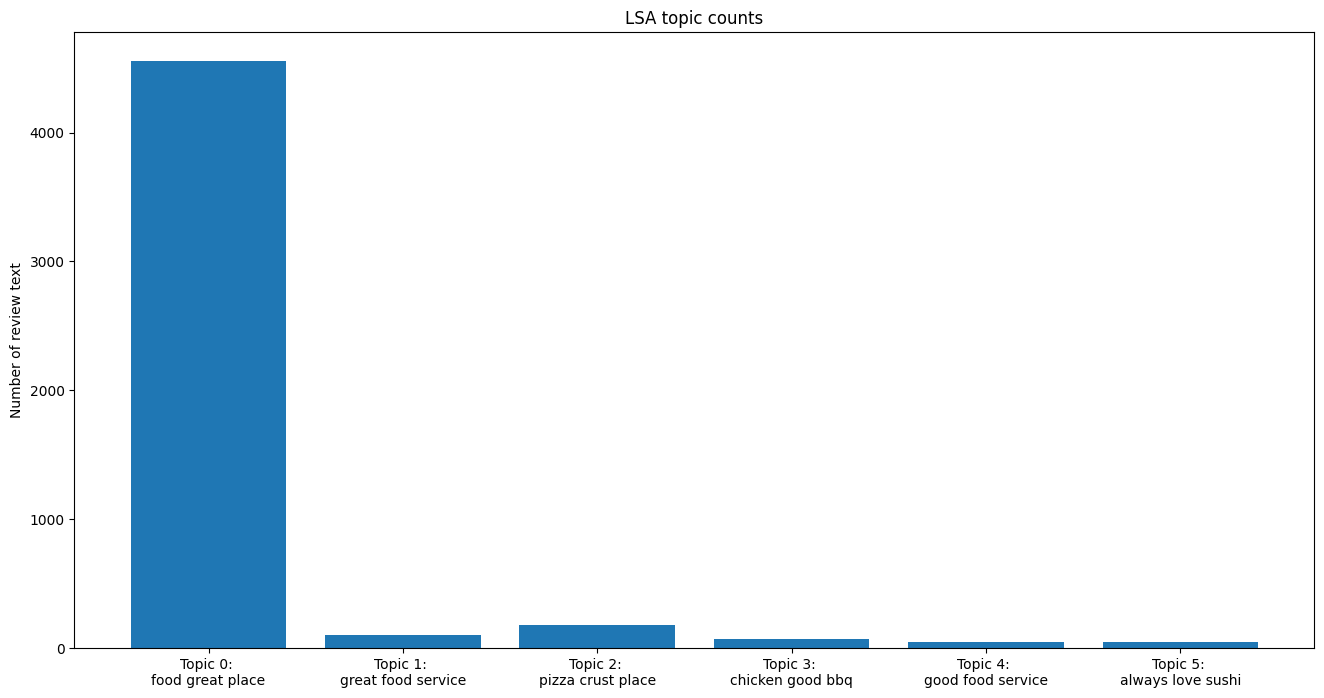

In [53]:
top_3_words = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of review text');
ax.set_title('LSA topic counts');
plt.show();